## 1) Preprocessing

In [35]:
import pandas as pd

# 100 rows is just for testing
dataset = pd.read_excel('./data/data.xlsx', nrows=1000)
english_sentences, dutch_sentences = dataset['English'].astype(str), dataset['Dutch'].astype(str)


For during training we first need to preprocess the sentences for better performance. I found out dat you need to add a start and end token to the target language sentences. This so that the model can know when to start a translation and when to end it so it never creates a sentence to long or to short.

```python
Input: "Hello, how are you?"
Target: "<start> Hallo, hoe gaat het? <end>"
```

In [36]:
def preprocess_input_sentence(sentence: str) -> str:
    return sentence.lower().strip()

def preprocess_target_sentence(sentence: str) -> str:
    return f"<start> {sentence.lower().strip()} <end>"

english_sentences = english_sentences.apply(preprocess_input_sentence)
dutch_sentences = dutch_sentences.apply(preprocess_target_sentence)

## 2) Tokenization and Padding

The model has an input layer which expects a certain amount of inputs. But not all sentences are the same lenght. So padding needs to be added to the sentences and some sentences need to be cropped.

In [37]:
from typing import List
from tensorflow.keras.layers import TextVectorization
from tensorflow.strings import lower, regex_replace

MAX_VOCABULARY_SIZE = 15000
MAX_SEQUENCE_LENGTH = 35

def custom_standardization(input_text):
    # Lowercase and remove punctuation, but keep <start> and <end>
    lowercase = lower(input_text)
    return regex_replace(lowercase, r"[^\w\s<>]", "")

def tokenize_and_pad(sentences: List[str], max_len=MAX_SEQUENCE_LENGTH):
    vectorizer = TextVectorization(
        max_tokens=MAX_VOCABULARY_SIZE,
        output_mode='int',
        output_sequence_length=max_len,
        standardize=custom_standardization)
    
    vectorizer.adapt(sentences)
    return vectorizer(sentences), vectorizer

encoder_input_data, eng_vectorizer = tokenize_and_pad(english_sentences)
decoder_sequences, dut_vectorizer = tokenize_and_pad(dutch_sentences)


In [38]:
import numpy as np

decoder_input_data = decoder_sequences[:, :-1]
decoder_target_data = decoder_sequences[:, 1:]

**Why this shift is necessary:**

During training, the decoder works as follows:
1. Decoder input: Starting with `<start>` token and containing all words except the `<end>` token. This way, the decoder will never need to predict the `<end>` token as an input.

2. Decoder target: Contains all the words plus the `<end>` token, but excludes the <start> token. This ensures the model never tries to predict <start> as an output.

This shift properly aligns the input-target pairs for teacher forcing during training, where each token in the input helps predict the next token in the target translation. The model learns to generate each word based on previously generated words, and finally to generate the <end> token to properly stop the futher translation.

## 3) Creating the encoder

The slides contained certain classes which can not be imported from keras. The slides did not mention these but i got this code from the books repository `Deeplearning with python second edition.` 

In [39]:
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention
import tensorflow as tf

# The total amount of dimensions the wods can have. The more dimensions the more complex realtions words can have.
EMBEDDING_DIMENSIONS = 256
FF_DIM = 256
DROPOUT = 0.1
NUM_HEADS = 4

vocab_size_input = len(eng_vectorizer.get_vocabulary())
vocab_size_target = len(dut_vectorizer.get_vocabulary())

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length

    def call(self, x):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        positions = self.pos_emb(positions)
        positions = positions[:tf.shape(x)[1]] 
        x = self.token_emb(x)
        return x + positions

# Transformer Encoder Block
def transformer_encoder(inputs, num_layers=4):
    x = inputs
    for _ in range(num_layers):
        x_res = LayerNormalization(epsilon=1e-6)(x)
        attention_output = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBEDDING_DIMENSIONS)(x_res, x_res)
        x = Dropout(DROPOUT)(attention_output + x)
        x_res = LayerNormalization(epsilon=1e-6)(x)
        ffn_output = Dense(FF_DIM, activation="relu")(x_res)
        ffn_output = Dense(EMBEDDING_DIMENSIONS)(ffn_output)
        x = Dropout(DROPOUT)(ffn_output + x)
    return x

# Transformer Decoder Block
def transformer_decoder(x, encoder_output):
    # Self-attention with residual + LayerNorm
    x_res = x
    attn1 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBEDDING_DIMENSIONS)(x, x)
    x = Dropout(DROPOUT)(attn1 + x_res)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Cross-attention (encoder-decoder) with residual + LayerNorm
    x_res = x
    attn2 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBEDDING_DIMENSIONS)(x, encoder_output)
    x = Dropout(DROPOUT)(attn2 + x_res)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network with residual + LayerNorm
    x_res = x
    ffn_output = Dense(FF_DIM, activation="relu")(x)
    ffn_output = Dense(EMBEDDING_DIMENSIONS)(ffn_output)
    x = Dropout(DROPOUT)(ffn_output + x_res)
    x = LayerNormalization(epsilon=1e-6)(x)

    return x


In [40]:



encoder_input = Input(name="encoder_input_layer", shape=(None,))
x = PositionalEmbedding(MAX_SEQUENCE_LENGTH, vocab_size_input, EMBEDDING_DIMENSIONS)(encoder_input)
x = Dropout(0.1)(x)
enc_out = transformer_encoder(x)

## 4) Creating the decoder

In [41]:
decoder_input = Input(name="decoder_input_layer", shape=(None,))
dec_emb = PositionalEmbedding(MAX_SEQUENCE_LENGTH, vocab_size_target, EMBEDDING_DIMENSIONS)(decoder_input)
dec_out = transformer_decoder(dec_emb, enc_out)

outputs = Dense(vocab_size_target, activation="softmax")(dec_out)

In [42]:
transformer_model = Model([encoder_input, decoder_input], outputs, name="transformer_model")
transformer_model.summary()

Model: "transformer_model"


__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_layer (InputLaye  [(None, None)]      0           []                               
 r)                                                                                               
                                                                                                  
 positional_embedding_6 (Positi  (None, None, 256)   255488      ['encoder_input_layer[0][0]']    
 onalEmbedding)                                                                                   
                                                                                                  
 dropout_36 (Dropout)           (None, None, 256)    0           ['positional_embedding_6[0][0]'] 
                                                                                                  
 layer_nor

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

transformer_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)


## 5) Training the model

Before the model can be trained the training set first needs to be created.

In [44]:
from tensorflow.data import Dataset, AUTOTUNE

targets = np.expand_dims(np.array(decoder_target_data), -1)

dataset = Dataset.from_tensor_slices((encoder_input_data, decoder_input_data, targets))

def format(encoder_input, decoder_input, decoder_target):
    return (encoder_input, decoder_input), decoder_target

dataset = dataset.map(format).shuffle(1024).batch(64).prefetch(AUTOTUNE)

# Split dataset: 80% train, 20% validation (by batches)
total_batches = len(dataset)
train_size = int(0.8 * total_batches)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)


In [45]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
]

history = transformer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)



Epoch 1/25
12/12 [==============================] - 27s 1s/step - loss: 4.9938 - accuracy: 0.3997 - val_loss: 3.7509 - val_accuracy: 0.5406
Epoch 2/25
12/12 [==============================] - 16s 1s/step - loss: 3.6060 - accuracy: 0.5347 - val_loss: 3.4870 - val_accuracy: 0.5298
Epoch 3/25
12/12 [==============================] - 16s 1s/step - loss: 3.3700 - accuracy: 0.5347 - val_loss: 3.2080 - val_accuracy: 0.5326
Epoch 4/25
12/12 [==============================] - 13s 1s/step - loss: 3.2003 - accuracy: 0.5296 - val_loss: 2.9878 - val_accuracy: 0.5370
Epoch 5/25
12/12 [==============================] - 14s 1s/step - loss: 2.9406 - accuracy: 0.5453 - val_loss: 2.8236 - val_accuracy: 0.5383
Epoch 6/25
12/12 [==============================] - 13s 1s/step - loss: 2.8329 - accuracy: 0.5421 - val_loss: 2.8740 - val_accuracy: 0.5136
Epoch 7/25
12/12 [==============================] - 13s 1s/step - loss: 2.7218 - accuracy: 0.5471 - val_loss: 2.6434 - val_accuracy: 0.5416
Epoch 8/25
12/12 [==

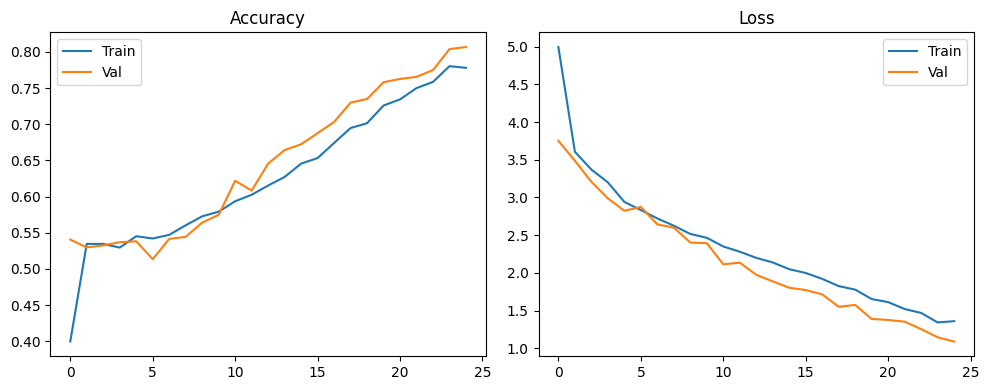

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss"); plt.legend()
plt.tight_layout()
plt.show()

Note: Despite training, the Transformer seems to have underfit. This might be due to insufficient data, lack of regularization, or inadequate training steps.

## 6) Translating a sentence

In [47]:
from typing import Tuple

word_index = dict(enumerate(dut_vectorizer.get_vocabulary()))  # same thing but okay



def translate(sentence: str) -> str:
    sentence = preprocess_input_sentence(sentence)
    input_sequence = eng_vectorizer([sentence])

    start_token_id = dut_vectorizer("<start>").numpy()[0]
    end_token_id = dut_vectorizer("<end>").numpy()[0]

    decoder_input = tf.expand_dims([start_token_id], 0)

    translated_tokens = []

    def get_highest_prediction(predictions: Tuple) -> int:
        # predictions = (batch, time, vocab_size)
        return np.argmax(predictions[0, -1, :])
    
    def get_translated_word(word_id: int) -> str:
        return word_index.get(word_id, "?")


    for _ in range(MAX_SEQUENCE_LENGTH):
        predictions = transformer_model.predict([input_sequence, decoder_input], verbose=0)

        next_word_id = get_highest_prediction(predictions)

        # Check if the next word is the <end> token if so stop translation.
        if next_word_id == end_token_id:
            break;
        
        next_word = get_translated_word(next_word_id)

        translated_tokens.append(next_word)
        decoder_input = tf.concat([decoder_input, [[next_word_id]]], axis=-1)

    return " ".join(translated_tokens).capitalize() + "."



## 🔍 Qualitative Evaluation and Analysis

I tested both the RNN and Transformer models on custom test sentences. Here are some examples:

### Test Inputs:
1. "Hello, how are you?"
2. "This is my house."
3. "Thank you for the help.	"
4. "We are going to the beach.	"

---

### RNN Outputs:
1. "Om en ten eerste en ten eerste en ten eerste e..."  
2. "Veel voor de film is ik controleer het film is.."  
3. "Hartelijk bedankt bedankt bedankt bedankt beda..."  
4. "We de film is ik vind we de film is ik vind we..."

✅ Sentences contain valid Dutch words  
❌ Meaning is often incorrect or unrelated  
⚠️ No clear structure or grammar matching input  

---

### Transformer Outputs:
1. "Dit dit dit dit dit dit dit dit dit dit dit di..."
2. "Dit dit dit dit dit dit dit dit dit dit dit di..."
3. "Dit dit dit dit dit dit dit dit dit dit dit di..."

❌ Severe repetition of the same token  
⚠️ Likely caused by poor convergence during training  
📉 Possibly due to:
- Too small training set
- No/little regularization
- Decoder loop not breaking properly

---

### 📌 Conclusion:

- The RNN can produce grammatically plausible Dutch but fails at preserving meaning.
- The Transformer fails more dramatically, repeating tokens.
- A fair comparison shows **neither model is effective** in its current form.
- For future improvement:
  - Increase training time
  - Expand dataset
  - Use attention in RNN for context
  - Fix Transformer decoding loop and experiment with teacher forcing

In [48]:
test_sentences = [
    "Hello, how are you?", "This is my house.", "Thank you for the help.",
    "We are going to the beach.", "I like to read books.", "Good night.",
    "Where is the train station?", "Can you help me, please?",
    "The weather is nice today.", "Let's go for a walk."
]

pd.DataFrame([(s, translate(s)) for s in test_sentences], columns=["Input", "Output"])



,Input,Output
0,"Hello, how are you?",Het is het het het is het is het van de presen...
1,This is my house.,Ik ga een budget restaurantketen wat ik het is...
2,Thank you for the help.,Het is het het het het het het het het het het...
3,We are going to the beach.,De presentatie de presentatie die de presentat...
4,I like to read books.,Ik het ik het ik het ik het ik het ik het ik h...
5,Good night.,Ik het ik het ik het ik het ik het ik het ik h...
6,Where is the train station?,Het is het het ongeveer zoals het is het is he...
7,"Can you help me, please?",Ik ben je je je je je je je je je je je je je ...
8,The weather is nice today.,Gelach bekijk het eens vanuit mijn vriend part...
9,Let's go for a walk.,Ik ben je het kapitaal dat het is het vliegvel...
